# Load pretrain model

In [38]:
from Score_Matching import *
from FLIPD import *
import torch 
from tqdm import tqdm
import numpy as np
import os
import matplotlib.pyplot as plt

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [23]:
score_model = ScoreNet(
    image_dim=(1,28,28), 
    use_condition=True, 
    num_classes=10, 
    device = device
)

In [24]:
# Load model with lastest checkpoint
def find_last_folder():
    all_subdirs = ['./Score_Matching/checkpoints/' + d for d in os.listdir('./Score_Matching/checkpoints/') if os.path.isdir(os.path.join('./Score_Matching/checkpoints/', d))]
    return max(all_subdirs, key=os.path.getmtime)

last_checkpoint = find_last_folder()
print("Loading model from checkpoint: ", last_checkpoint)

score_model.model.load_state_dict(torch.load(last_checkpoint + '/model.pt', map_location=device))

Loading model from checkpoint:  ./Score_Matching/checkpoints/20250114-100745


<All keys matched successfully>

# Test model

In [25]:
# # Sampling 
# sampler = Predictor_Corrector_Sampler(
#     score_model=score_model, 
#     signal_to_noise_ratio=0.16, 
#     device=device,
#     epsilon=1e-6
# )

# image_state = sampler.sample(
#     num_steps=100, 
#     batch_size=1, 
#     sample_condition=torch.tensor([0]).to(device)
# )

# # show image
# import matplotlib.pyplot as plt
# plt.imshow(image_state.squeeze().cpu().detach().numpy(), cmap='gray')

# Calculate FLIPD 

In [26]:
metric = FLIPD(
    score_model=score_model
)

In [34]:
batch_size = 1 
condition_label = [0]

x = torch.randn(batch_size, 1, 28, 28).to(device)
y = torch.tensor(condition_label).to(device)
t_0 = torch.ones(batch_size).to(device) * (0.999999)

# Compute the FLIPD score
metric_score = metric.flipd(t_0, x, y)
print("FLIPD score: ", metric_score)
print(metric_score.shape)

FLIPD score:  tensor([[[[785.0867, 784.3537, 801.5764, 791.7820, 802.3713, 802.4904, 799.0140,
           802.4905, 799.0086, 798.4280, 784.8847, 802.4905, 785.1749, 802.4905,
           802.4905, 791.4944, 802.4905, 784.0049, 802.4846, 802.3643, 796.1561,
           802.4902, 798.3303, 802.4858, 802.4905, 793.7251, 801.7403, 802.4904],
          [800.8855, 802.4732, 787.7336, 784.0000, 802.4904, 784.0000, 802.4905,
           797.9766, 792.7396, 802.4726, 784.1552, 802.4905, 802.4904, 802.4904,
           796.2051, 802.2340, 802.4901, 802.4905, 796.1060, 802.4905, 784.5641,
           784.0002, 802.4905, 798.9263, 800.8809, 788.3996, 795.9963, 802.4857],
          [802.3395, 797.4911, 802.3816, 802.4890, 802.4905, 802.4905, 802.4556,
           787.7428, 789.7922, 802.4905, 795.3378, 785.7864, 802.4900, 802.4903,
           802.4868, 784.1449, 792.7635, 802.4869, 801.2547, 802.4904, 802.4245,
           802.4110, 798.8375, 797.6668, 784.3222, 802.4904, 802.4905, 791.4427],
          [

In [44]:
time_steps = torch.linspace(1., 1e-5, 40)
step_size = time_steps[0] - time_steps[1]

image_state = x.clone()

flipd_hist = []

for step in tqdm(time_steps): 
    batch_time_step = torch.ones(batch_size, device=score_model.device) * step
    score = score_model.model(batch_time_step, image_state, y)
    score_norm = torch.norm(score.reshape(score.shape[0], -1), dim=-1).mean()
    
    # # Corrector step (Langevin MCMC)
    noise_norm = torch.sqrt(torch.prod(torch.tensor(image_state.shape[1:])))
    langevin_step_size = 2 * (0.16 * noise_norm / score_norm)**2
    image_state = image_state + langevin_step_size * score + torch.sqrt(2 * langevin_step_size) * torch.randn_like(image_state)
    
    # Predictor step (Euler-Maruyama)
    g = score_model.sde.sde(torch.zeros_like(image_state), batch_time_step)[1]
    x_mean = image_state + (g**2)[:, None, None, None] * score_model.model(batch_time_step, image_state, y) * step_size
    image_state = x_mean + torch.sqrt(g**2 * step_size)[:, None, None, None] * torch.randn_like(image_state)

    flipd_hist.append(metric.flipd(t_0, image_state, y))

100%|██████████| 40/40 [00:03<00:00, 13.23it/s]


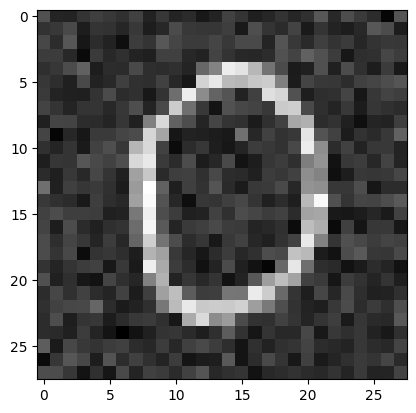

In [45]:
plt.imshow(image_state.squeeze().cpu().detach().numpy(), cmap='gray')

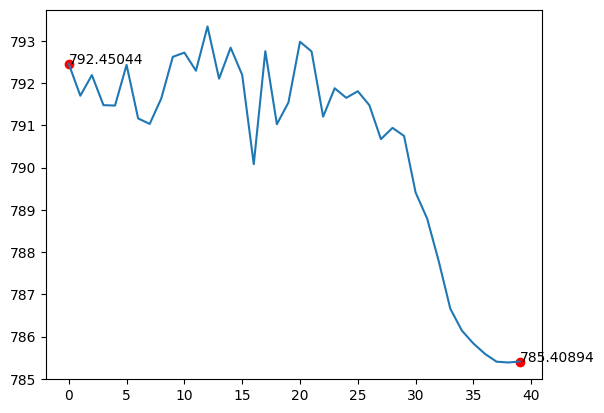

In [46]:
step = [i for i in range(0, len(flipd_hist), 100)]
step = step + [len(flipd_hist)-1]
plt.figure()
for i in step:
    mean_flipd = flipd_hist[i].mean().detach().numpy()
    plt.plot(i, mean_flipd, 'ro')
    plt.text(i, mean_flipd, str(mean_flipd))

# Extract mean values from flipd_hist
mean_flipd_hist = [f.mean().detach().numpy() for f in flipd_hist]
plt.plot(mean_flipd_hist)